<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/06_insurance_federated_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Insurance - a Federated Learning Use Case.

Wrapup

## Setup
---

In [7]:
# Is a repo-clone and installs needed (e.g. in colabs)? 
need_clone_install = True

### Pull Repo

In [8]:
if need_clone_install:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

Cloning into 'fl-official-statistics-addon'...
remote: Enumerating objects: 914, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 914 (delta 66), reused 14 (delta 10), pack-reused 818
Receiving objects: 100% (914/914), 33.86 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (426/426), done.
/content/fl-official-statistics-addon/fl-official-statistics-addon
Already up to date.


### Installs

In [9]:
if need_clone_install: 
  !pip install --quiet nest_asyncio==1.5.6
  !pip install --quiet tensorflow_federated==0.20.0
  !pip install --quiet tensorflow_addons==0.20.0
  # or !pip install -r requirements.txt

# save with: !pip freeze > requirements.txt
!python --version

Python 3.9.16


### Imports

In [285]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow_addons.metrics import RSquare
import tensorflow_addons as tfa
import nest_asyncio
from sklearn.metrics import r2_score

np.random.seed(0)

## Ingestion and data split
---

In [200]:
df = pd.read_csv("https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


### Train-Test-Split

Cross Validation s. 
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 

In [46]:
from sklearn.model_selection import StratifiedKFold

In [201]:
nfolds = 5
cv = StratifiedKFold(n_splits = nfolds, random_state = 42, shuffle= True)
ind = 0
for train, test in cv.split(df, df.region):
  ind += 1
  df.loc[train, 'fold' + str(ind)] = 'train'
  df.loc[test,  'fold' + str(ind)] = 'test'


#### Check

Check of the train test ratios for each region and fold.

In [202]:
ptrains = []

for fold in range(1,6):
  ntrain = sum(df['fold' + str(fold)] == 'train')
  ntest = sum(df['fold' + str(fold)] == 'test')
  ptrain = ntrain / (ntrain + ntest); ptrains.append(ptrain)
  print(
      '(region, fold) =  (%s, %s), ntrain = %s, ntest = %s, ptrain = %.2f %%' %
      ('combined', fold, ntrain, ntest, ptrain * 100)
  )
print('=============================================================================')
for region in df.region.unique():
  for fold in range(1,6):
    df_temp = df[df.region == region]
    ntrain = sum(df_temp['fold' + str(fold)] == 'train')
    ntest = sum(df_temp['fold' + str(fold)] == 'test')
    ptrain = ntrain / (ntrain + ntest); ptrains.append(qtest)
    print(
        '(region, fold) = (%s, %s), ntrain =  %s, ntest =  %s, ptrain = %.2f %%' %
        (region, fold, ntrain, ntest, ptrain * 100)
    )


(region, fold) =  (combined, 1), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 2), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 3), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 4), ntrain = 1071, ntest = 267, ptrain = 80.04 %
(region, fold) =  (combined, 5), ntrain = 1071, ntest = 267, ptrain = 80.04 %
(region, fold) = (southwest, 1), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 2), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 3), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 4), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 5), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southeast, 1), ntrain =  291, ntest =  73, ptrain = 79.95 %
(region, fold) = (southeast, 2), ntrain =  291, ntest =  73, ptrain = 79.95 %
(region, fold) = (southeast, 3), ntrain =  291, ntest =  73, ptr

## Model

In [203]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer


def build_model(units = [40, 40, 20], activations = ['relu'] * 3, input_shape = [9]):
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))
  for ind in range(len(units)):
    model.add(Dense(units = units[ind], activation = activations[ind]))
  model.add(Dense(1))
  return model

build_model().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                400       
                                                                 
 dense_9 (Dense)             (None, 40)                1640      
                                                                 
 dense_10 (Dense)            (None, 20)                820       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


## Centralized neural networks
---

### Training

In [306]:
# inputs
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3'
            ]
target = 'charges'

# result list
hists = []
perfs = []

for fold in tqdm.tqdm(range(1, nfolds + 1)):
  # train test split

  #df.loc[(df['fold1'] == 'train'),features]
  X_train = df.loc[df['fold'+str(fold)] == 'train', features]
  X_test  = df.loc[df['fold'+str(fold)] == 'test', features]
  y_train = df[[target]][df['fold'+str(fold)] == 'train']
  y_test = df[[target]][df['fold'+str(fold)] == 'test']

  # reset model
  model = build_model(input_shape = [X_train.shape[1]])
  model.compile(
        loss = 'mean_squared_error', 
        optimizer = tf.optimizers.Adam(learning_rate = .05),
        # Adam + lower learning rate
        metrics = ["mae", 'mean_squared_error', r2_score], 
        run_eagerly = True
        )

  # train 
  rtime = time.time() 
  tf.random.set_seed(42)

  with tf.device('/device:GPU:0'):
    hist = model.fit(
        X_train, y_train,
        batch_size = 128, # <- higher batch_size
        shuffle = True,
        validation_split = 0.2,
        epochs = 100,
        verbose = 0
    )

  rtime = time.time() - rtime
  hists.append(hist)
  perf = hist.model.evaluate(X_test, y_test, verbose = 0)[1:]
  perfs.append(perf)
  print('========  fold %s  ========' % fold)
  print('training time: %.2f' % (rtime / 60))
  print("\n-- test performance --")
  print(pd.DataFrame({'measure': ["mae", 'mse', 'r2_score'],'value': perf}))
     

 20%|██        | 1/5 [01:22<05:30, 82.60s/it]

========  fold 1  ========
training time: 1.37
-- test performance --
    measure         value
0       mae  2.758656e+03
1       mse  2.799687e+07
2  r2_score  8.265215e-01


 40%|████      | 2/5 [02:50<04:13, 84.34s/it]

========  fold 2  ========
training time: 1.45
-- test performance --
    measure         value
0       mae  3.293964e+03
1       mse  2.838852e+07
2  r2_score  7.615580e-01


 60%|██████    | 3/5 [04:14<02:48, 84.08s/it]

========  fold 3  ========
training time: 1.37
-- test performance --
    measure         value
0       mae  2.513721e+03
1       mse  1.842971e+07
2  r2_score  8.539883e-01


 80%|████████  | 4/5 [05:48<01:26, 86.94s/it]

========  fold 4  ========
training time: 1.54
-- test performance --
    measure         value
0       mae  2.614897e+03
1       mse  1.955661e+07
2  r2_score  8.438855e-01


100%|██████████| 5/5 [08:10<00:00, 103.69s/it]

========  fold 5  ========
training time: 2.37
-- test performance --
    measure         value
0       mae  2.882264e+03
1       mse  2.638759e+07
2  r2_score  7.841126e-01


**Mean performance in the cross validation**

In [307]:
rsqs = [x[2] for x in perfs]
print('R^2: mean = %.2f, std = %.2f' % (np.mean(rsqs), np.std(rsqs)))

R^2: mean = 0.81, std = 0.04


### Evaluation

In [308]:
def plot_loss(hist, msr = 'loss'):
  """Plot the training history and save the figure.
  :param hist: The history object including the metrics to plot
  :type hist: keras.callbacks.History
  :param msr: The metrics to plot
  :type msr: str, optional
  """
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')

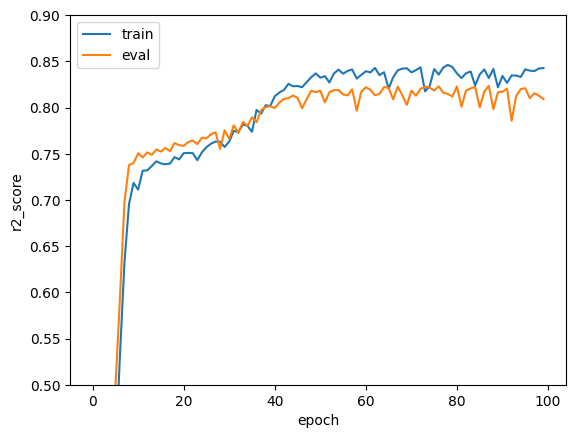

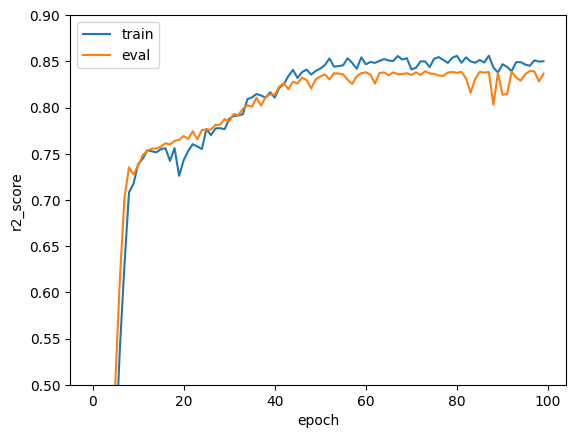

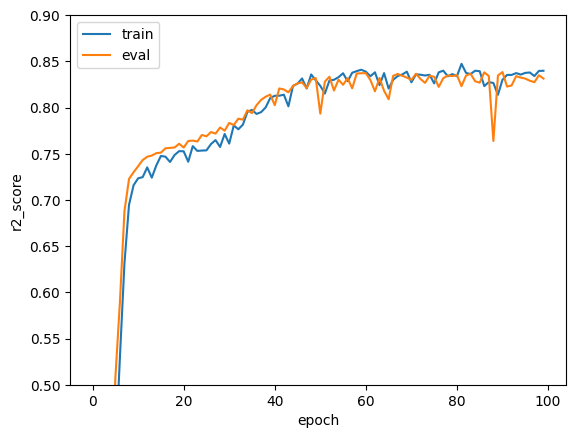

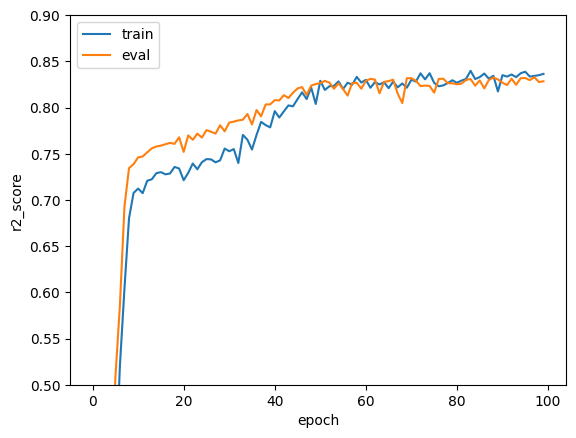

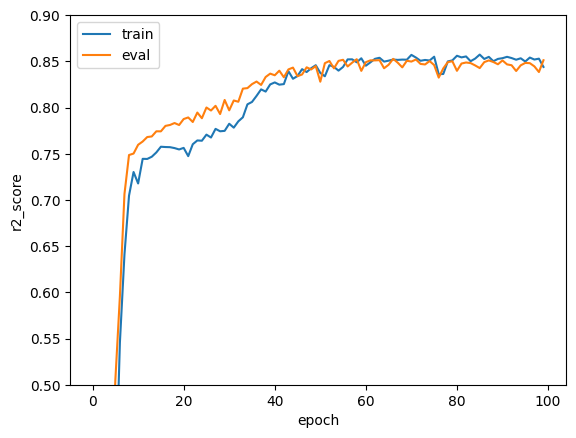

In [309]:
for ind in range(len(hists)):
  plot_loss(hists[ind], 'r2_score')
  plt.ylim([0.5, 0.9])
  plt.show()

# Appendix

In [ ]:
NUM_CLIENTS = 4
NUM_EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_BUFFER = 20
PREFETCH_BUFFER = 5
NUM_ROUNDS = 50
RUN_NAME = f'0,8-3({NUM_ROUNDS})-{NUM_EPOCHS}-epochs-{BATCH_SIZE}-batch-WithRegion/'

In [ ]:
syn_samples_per_region = 1000

def get_dataset_for_region(dataset, region_index, test_size_per_region=20):
    """Min-max scale and return data for a single, given region. The scaler must be fitted before.

    :param dataset: The dataset to get the regional data from
    :type dataset: pandas.DataFrame
    :param region_index: The index number of the region to return
    :type region_index: int
    :param test_size_per_region: The amount of values to separate for testing, default are 20
    :type test_size_per_region: int, optional
    :return: The dataset specific for the defined region, the test values, the test labels
    :rtype: tensorflow.python.data.ops.dataset_ops.PrefetchDataset, tuple of pandas.core.series.Series
    """
    region_ds = dataset[dataset['region'] == region_index]
    region_ds = region_ds.drop(columns=['region'])
    len = region_ds.shape[0]

    # The scaling into [0, 1] is not necessary anymore, it happens when the data loads already
    # region_ds[['age', 'bmi', 'children']] = scaler.transform(region_ds[['age', 'bmi', 'children']])

    X_test = region_ds.head(test_size_per_region)
    y_test = X_test.pop('charges')

    X_train = region_ds.tail(len - test_size_per_region)
    y_train = X_train.pop('charges')

    fed_train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))

    return (
        fed_train_dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER),
        (X_test, y_test)
    )

In [ ]:
# Create test and train sets and put them into random_client_ds, use four clients which are independent of the region
def get_dataset_random_region(dataset, num_clients=4, test_size_per_region=20):
    """Creates a list with client datasets independent of the region.

    :param dataset: The dataset to get the regional data from
    :type dataset: pandas.DataFrame
    :param num_clients: the number of clients create (equal big datasets per client), default value is 4 clients
    :type num_clients: int, optional
    :param test_size_per_region: The amount of values to separate for testing, default are 20
    :type test_size_per_region: int, optional
    :return: List of the prepared dataset with one entry per region, the test values and labels for each region
    :rtype: List of (tensorflow.python.data.ops.dataset_ops.PrefetchDataset, tuple of pandas.core.series.Series)"""
    size_of_client_ds = int(dataset.shape[0] / num_clients)

    dataset_to_split = dataset.copy()
    dataset_to_split.pop("region")
    random_client_ds = []
    for i in range(num_clients):
        sampled = dataset_to_split.sample(n=size_of_client_ds)
        dataset_to_split.drop(sampled.index)

        X_test = sampled.head(test_size_per_region)
        y_test = X_test.pop('charges')

        X_train = sampled.tail(size_of_client_ds - test_size_per_region)
        y_train = X_train.pop('charges')

        fed_train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))

        train_set = fed_train_dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)
        test_set = (X_test, y_test)

        random_client_ds.append((train_set, test_set))

    return random_client_ds

In [ ]:
# Training data for clients with regional data (each client one region)
test_size_per_region = 20
regions = ['region0', 'region1', 'region2', 'region3']

federated_insurance_data = [
    get_dataset_for_region(df.drop(regions, axis=1), i, test_size_per_region=test_size_per_region)
    for i in range(NUM_CLIENTS-1)]
federated_insurance_data

[(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
  (Empty DataFrame
   Columns: [age, sex, bmi, children, smoker]
   Index: [],
   Series([], Name: charges, dtype: float64))),
 (<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
  (Empty DataFrame
   Columns: [age, sex, bmi, children, smoker]
   Index: [],
   Series([], Name: charges, dtype: float64))),
 (<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
  (Empty DataFrame
   Columns: [age, sex, bmi, children, smoker]
   Index: [],
   Series([], Name: charges, dtype: float64)))]

In [ ]:
# Training data for clients with regional independent data
random_client_ds = get_dataset_random_region(df, num_clients=NUM_CLIENTS, test_size_per_region=test_size_per_region)

### Code Tests

In [ ]:
print("splitted datasets: {}".format(len(federated_insurance_data)))
print("------------------------------")
# Q: why range(NUM_CLIENTS-1) and, thus, only 3 clients?

# Q: how to output? -> does not work or nothing in it?
# -> i think its empty
list(federated_insurance_data[0][0].as_numpy_iterator())[:10]

splitted datasets: 3
------------------------------


[]

#### Show Tensor

In [ ]:
# Create a Tensor Object
X_train = df.iloc[:,0:4]
y_train = df['charges']
df2 = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))
df2

<_TensorSliceDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [ ]:
# Show Tensor Object
# S. https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset
list(df2.as_numpy_iterator())[:10]

[(array([0.02173913, 0.        , 0.3212268 , 0.        ]), 16884.924),
 (array([0.        , 1.        , 0.47914985, 0.2       ]), 1725.5523),
 (array([0.2173913 , 1.        , 0.45843422, 0.6       ]), 4449.462),
 (array([0.32608696, 1.        , 0.18146355, 0.        ]), 21984.47061),
 (array([0.30434783, 1.        , 0.34759214, 0.        ]), 3866.8552),
 (array([0.2826087 , 0.        , 0.26311542, 0.        ]), 3756.6216),
 (array([0.60869565, 0.        , 0.47027172, 0.2       ]), 8240.5896),
 (array([0.41304348, 0.        , 0.31692225, 0.6       ]), 7281.5056),
 (array([0.41304348, 1.        , 0.37315039, 0.4       ]), 6406.4107),
 (array([0.91304348, 0.        , 0.26580576, 0.        ]), 28923.13692)]

## Model Builder

In [23]:
u = [10] * 3
len(u)

3

In [27]:
range(1,len(u)+1)

range(1, 4)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer


def build_model(units = [10] * 3, activations = ['relu'] * 3, input_dim = 9):
  model = Sequential()
  
  return activations

build_model()

['relu', 'relu', 'relu']

In [ ]:
from keras.layers import ReLU
from keras.models import Sequential
from keras.layers import Dense, InputLayer

def create_keras_model(
  input_features = 9
  ):

  model = Sequential([
    Dense(40, input_dim = 9, activation = 'relu'),
    Dense(40, activation = 'relu'),
    Dense(20, activation = 'relu'),
    Dense(1)
    ])
  #model = Sequential()
  #model.add(Dense(40, input_dim=9))
  #model.add(ReLU())
  #model.add(Dense(40))
  #model.add(ReLU())
  #model.add(Dense(20))
  #model.add(ReLU())
  #model.add(Dense(1))
  return model

In [ ]:
from keras.layers import ReLU
from keras.models import Sequential
from keras.layers import Dense

def build_model(
  input_features = 9
  ):
  model = Sequential()
  model.add(Dense(40, input_dim=9))
  model.add(ReLU())
  model.add(Dense(40))
  model.add(ReLU())
  model.add(Dense(20))
  model.add(ReLU())
  model.add(Dense(1))
  return model


# A helper function for federated learning
def model_fn(    
  input_features = 9):

  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model(
          input_features = input_features
  )
  return tff.learning.models.from_keras_model(
      keras_model,
      # without region: 
      #input_spec = federated_insurance_data[0][0].element_spec,
      input_spec = random_client_ds[0][0].element_spec,
      loss = tf.keras.losses.MeanAbsoluteError(),
      #loss = tf.keras.losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.MeanAbsoluteError()
      #metrics = [tf.keras.losses.MeanSquaredError()
      #,tfa.metrics.RSquare()
      ]
  )

# Helper functions for different features as input
def model_fn_5():
    return model_fn(5)

def model_fn_5_mod():
  return model_fn(5, initializer = 'glorot_uniform', activation = 'relu')

def model_fn_9():
  return model_fn(9)

def model_fn_9_mod():
  return model_fn(9, initializer = 'glorot_uniform', activation = 'relu')

## Federated Learning

### Tuned Model

#### Create Learning Process

In [ ]:
# Create iterative learning process which will perform the federated learning
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn_9,
    client_optimizer_fn=lambda: tf.optimizers.Adam(learning_rate = .05),
    server_optimizer_fn=lambda: tf.optimizers.Adam(learning_rate = .05),)

In [ ]:
# The initial setup of the learning process
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9,40],
      float32[40],
      float32[40,40],
      float32[40],
      float32[40,20],
      float32[20],
      float32[20,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[9,40],
    float32[9,40],
    float32[40],
    float32[40],
    float32[40,40],
    float32[40,40],
    float32[40],
    float32[40],
    float32[40,20],
    float32[40,20],
    float32[20],
    float32[20],
    float32[20,1],
    float32[20,1],
    float32[1],
    float32[1]
  >
>@SERVER)


#### Train

In [ ]:
state = iterative_process.initialize()

In [ ]:
# Train the federated model with random clients
for round_num in tqdm.tqdm(range(1, NUM_ROUNDS)):
    result = iterative_process.next(state, [f[0] for f in random_client_ds])
    state = result.state
    metrics = result.metrics
    for name, value in metrics['client_work']['train'].items():
        tf.summary.scalar(name, value, step=round_num)

100%|██████████| 49/49 [00:54<00:00,  1.12s/it]


In [ ]:
result.metrics

OrderedDict([('distributor', ()),
             ('client_work',
              OrderedDict([('train',
                            OrderedDict([('mean_absolute_error', 2147.164),
                                         ('loss', 2148.4714),
                                         ('num_examples', 62800),
                                         ('num_batches', 492)]))])),
             ('aggregator',
              OrderedDict([('mean_value', ()), ('mean_weight', ())])),
             ('finalizer', OrderedDict([('update_non_finite', 0)]))])

In [ ]:
result.state
# all weights are zero
# -> nothing is learned 

LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[ 1.4189123 ,  1.7389028 ,  0.07312496,  1.5636287 , -0.35117736,
         0.02626007,  1.2126486 , -0.49722698,  1.6391435 ,  1.6941264 ,
         1.2193762 ,  1.7821853 ,  1.6029737 ,  0.8546293 ,  1.2168341 ,
         1.7737147 ,  1.4188691 ,  1.3687578 ,  0.06397991,  1.4759294 ,
        -0.00476585,  0.9762718 ,  0.6702352 ,  0.5839205 ,  1.3484639 ,
         1.534091  ,  1.533158  ,  0.35992745,  1.2923716 ,  0.02302267,
         1.4433652 ,  0.5868061 ,  1.5460756 , -0.42014095, -0.20809455,
        -0.5650707 , -0.67297524,  1.2811157 ,  0.18986656,  1.5540348 ],
       [-0.27092746, -0.22524552, -0.3120267 , -0.28786334,  0.1451848 ,
         0.15787664, -0.37949395, -0.03356574, -0.21480867,  0.40005827,
        -0.719972  ,  0.14270301, -0.26058057, -1.6049917 ,  0.32306284,
         0.37985757, -0.21105848, -0.30480587, -0.25796545, -0.47293037,
        -0.04555012,  0.10164984,  0.3313538 ,  0.23410

#### Evaluate

In [ ]:
# Create the test data for model evaluation
X_test = pd.concat([f[1][0] for f in random_client_ds])
y_test = pd.concat([f[1][1] for f in random_client_ds])

test_sets = [tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(np.expand_dims(el[1][0], axis=0)), 
    tf.convert_to_tensor(np.expand_dims(el[1][1], axis=0)))) 
    for el in random_client_ds]

In [ ]:
# Model evaluation
evaluation = tff.learning.build_federated_evaluation(model_fn_9)
# print(evaluation.type_signature.formatted_representation())
model_weights = iterative_process.get_model_weights(state)
train_metrics = evaluation(model_weights, test_sets)
train_metrics

<ipython-input-38-552d4a23315f>:2: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  evaluation = tff.learning.build_federated_evaluation(model_fn_9)


OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 3185.3452),
                           ('loss', 3185.3452),
                           ('num_examples', 80),
                           ('num_batches', 4)]))])

In [ ]:
# Create model from training results and evaluate
model = create_keras_model(input_features = 9)
model_weights.assign_weights_to(model)
model.compile(
    loss=tf.losses.mae,
    # loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(),
    metrics=["mae", 'mean_squared_error']
)
# The evaluation results, for technical reasons the metrics_names is called afterwards. However, its order fits to the results
print(model.evaluate(X_test, y_test))
print(model.metrics_names)

3/3 [==============================] - 0s 7ms/step - loss: 3185.3455 - mae: 3185.3455 - mean_squared_error: 42205208.0000
[3185.345458984375, 3185.345458984375, 42205208.0]
['loss', 'mae', 'mean_squared_error']


Results federated:

fl-loss (mae): 2280.2578 
🚀 JW

OH: 3185.3455